# ETL "Extracción, transformación y carga"

El proceso ETL se realiza con el fin de preparar los datos y estructurarlos de manera adecuada para su posterior análisis, almacenamiento o presentación. Con los siguientes pasos: 

1. Integración de datos: Los extraemos del readme en formato Excel y los centralizamos con el fin de procesarlos 
2. Limpieza de los datos: Validamos errores del archivo, valores nulos, duplicados u otras inconsistencias con la finalidad de garantizar su calidad y consistencia.
3. Transformación de datos: Los adaptamos segun nuestras necesidades especificas de analisis como realizar derivaciones de nuesvas variables. 
4. Preparación para su analisis: Con el fin de poder aplicar el EDA.


## Instalaciones e importaciones

In [1]:
import numpy as np
import pandas as pd
import re

#import pandas_alive
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import folium
from folium.plugins import HeatMap
from summarytools import dfSummary


%load_ext autoreload
%autoreload 2
import utils

import warnings
warnings.filterwarnings("ignore")

### Extracción y lectura de los datasets

In [2]:
HECHOS = pd.read_excel(r"C:\Users\melan\Desktop\PI 2\PI\Datasets\homicidios.xlsx", sheet_name="HECHOS")
VICTIMAS = pd.read_excel(r"C:\Users\melan\Desktop\PI 2\PI\Datasets\homicidios.xlsx", sheet_name="VICTIMAS")

LESIONES= pd.read_excel(r"C:\Users\melan\Desktop\PI 2\PI\Datasets\lesiones.xlsx")


## Tratamiento de los datos del dataset `HECHOS`

In [3]:
HECHOS.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


### Datos generales

In [4]:
HECHOS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

El conjunto de datos presenta 21 variables (columnas) y 696 registros lo que se pueden ver a continuación.

In [5]:
# Se observan las columnas de dataset
HECHOS.columns

Index(['ID', 'N_VICTIMAS', 'FECHA', 'AAAA', 'MM', 'DD', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA', 'ACUSADO'],
      dtype='object')

### Normalización 

Dado que algunos nombres de columna estan en minúsculas y otras en mayúscula, se decide estanadarizar los nombres de la siguiente forma.

In [6]:
# Se coloca la primera en mayúscula
HECHOS.columns = [x.capitalize() for x in HECHOS.columns]
# Se reemplazan los guiones por espacios
HECHOS.columns = HECHOS.columns.str.replace('_', ' ')
# Se renombran algunas columnas
HECHOS = HECHOS.rename(columns={'N victimas': 'Cantidad víctimas',
                                                      'Aaaa':'Año',
                                                      'Mm':'Mes',
                                                      'Dd':'Día',
                                                      'Hh':'Hora entera',
                                                      'Xy (caba)':'XY (CABA)',
                                                      'Victima': 'Víctima'})
HECHOS.columns

Index(['Id', 'Cantidad víctimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora entera', 'Lugar del hecho', 'Tipo de calle', 'Calle', 'Altura',
       'Cruce', 'Dirección normalizada', 'Comuna', 'XY (CABA)', 'Pos x',
       'Pos y', 'Participantes', 'Víctima', 'Acusado'],
      dtype='object')

###  Limpieza

#### 1. Tratamiento de Datos Nulos.

In [7]:
HECHOS.isnull().sum()

Id                         0
Cantidad víctimas          0
Fecha                      0
Año                        0
Mes                        0
Día                        0
Hora                       0
Hora entera                0
Lugar del hecho            0
Tipo de calle              0
Calle                      1
Altura                   567
Cruce                    171
Dirección normalizada      8
Comuna                     0
XY (CABA)                  0
Pos x                      0
Pos y                      0
Participantes              0
Víctima                    0
Acusado                    0
dtype: int64

En cuanto a los valores faltantes, hay 747 valores nulos, que representan el 5.1% de todos los datos y se ubican en las columnas 'Altura', 'Cruce' y 'Dirección normalizada'.

En la columna **'Altura'** faltan el 81.5% de los datos, debido a que este dato se completa cuando el hecho ocurre en algún punto de la calle (altura de la calle) y la mayoría de los hechos registrados ocurrieron en esquinas. Por este motivo, se considera que no es un dato relevante para el análsis y se decide eliminarlo del conjunto. Adicionalmente, este dato se encuentra en la columna 'Lugar del hecho' y 'Dirección normalizada'. A continuación se muestra un ejemplo de este comprtamiento, donde las dos primeras filas son esquinas y la tercera es en un punto de la cuadra.

In [8]:
HECHOS[["Altura", "Calle", "Dirección normalizada", "Cruce"]][:5]

,Altura,Calle,Dirección normalizada,Cruce
0,NaN,PIEDRA BUENA AV.,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...","FERNANDEZ DE LA CRUZ, F., GRAL. AV."
1,NaN,"PAZ, GRAL. AV.","PAZ, GRAL. AV. y DE LOS CORRALES AV.",DE LOS CORRALES AV.
2,2034.0,ENTRE RIOS AV.,ENTRE RIOS AV. 2034,NaN
3,NaN,LARRAZABAL AV.,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.","VILLEGAS, CONRADO, GRAL."
4,NaN,SAN JUAN AV.,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.","SAENZ PE?A, LUIS, PRES."


In [9]:
HECHOS[HECHOS["Dirección normalizada"].isnull()][["Dirección normalizada", "Cruce","Altura", "Calle"]]

,Dirección normalizada,Cruce,Altura,Calle
38,NaN,NaN,NaN,"LUGONES, LEOPOLDO AV."
106,NaN,NaN,NaN,AUTOPISTA BUENOS AIRES - LA PLATA
119,NaN,NaN,NaN,NaN
180,NaN,NaN,NaN,AUTOPISTA PERITO MORENO
181,NaN,NaN,NaN,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.
313,NaN,NaN,NaN,"LUGONES, LEOPOLDO AV."
546,NaN,NaN,NaN,"LUGONES, LEOPOLDO AV."
621,NaN,NaN,NaN,AUTOPISTA BUENOS AIRES - LA PLATA


Tras examinar datos nulos, que representan el 5,1% del dataset; distribuidos en tres columnas **`Altura`**, **`Dirección Normalizada`**, **`Cruce`** y **`Calle`**. 
- Para el caso de **`Calle`** tiene un solo dato nulo.
- Para el caso de  **`Dirección Normalizada`** 8 nulos. 
- Para el caso de **`Cruce`** tiene 171 nulos, siendo el 24,56% del los datos de la columna.
- Para el caso de **`Altura`** tiene 567 nulos que representan el 81,5% de datos de la columna

Analizando los datos de la `Altura` se procede a eliminarla debido a la gran cantidad de faltantes y no existiendo manera de poder rellenar las colummas; ya que altura se refiere a la numeración de la calle donde se produce el siniestro y la mayoria de los casos se producen en cruces o esquinas.
La columna `Cruce` solo va a tener dato cuando el hecho se porduce en un cruce de calles, por lo que se conserva de esta manera.
La columna `Dirección Normalizada` no tiene posibilidad de completarse con las columnas del dataset; pero contiene solo 1,1% de nulos por lo se conserva de esta manera.

In [10]:
# Se elimina la columna 'Altura' ya que no tiene información relevante
HECHOS = HECHOS.drop('Altura', axis=1)
HECHOS.columns

Index(['Id', 'Cantidad víctimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora entera', 'Lugar del hecho', 'Tipo de calle', 'Calle', 'Cruce',
       'Dirección normalizada', 'Comuna', 'XY (CABA)', 'Pos x', 'Pos y',
       'Participantes', 'Víctima', 'Acusado'],
      dtype='object')

En cuanto a la colomna **'Cruce'** es una variable categórica, de tipo string, que contiene 317 valones distintos y donde hay un 24,6% de valores faltantes. Al contrario de la variable anterior, esta variable no tiene dato cuando se trata de un hecho ocurrido en un cruce. Esta columna puede ser interesante para evaluar si los hechos ocurren en esquinas o en algún punto de la cuadra. A continuación, se observa la columna 'Cruce' en relación a 'Lugar del hecho' y 'Tipo de calle'.

In [11]:
# Se observa los valores nulos de cruce en relación con 'Lugar del hecho' y 'Tipo de calle'
HECHOS[HECHOS['Cruce'].isnull()][['Cruce', 'Lugar del hecho', 'Tipo de calle']][:15]


,Cruce,Lugar del hecho,Tipo de calle
2,NaN,AV ENTRE RIOS 2034,AVENIDA
9,NaN,AV ENTRE RIOS 1366,AVENIDA
14,NaN,SUIPACHA 156,CALLE
33,NaN,LIMA 1483,CALLE
35,NaN,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI KM....,AUTOPISTA
38,NaN,AUTOPISTA LUGONES PK 10000,AUTOPISTA
42,NaN,AV LUIS MARIA CAMPOS 30,AVENIDA
43,NaN,LIMA 1471,CALLE
50,NaN,MAGARIÑOS CERVANTES 3900,CALLE
59,NaN,AV LA PLATA 2384,AVENIDA


In [12]:
# Se ven los valores NO nulos de cruce en relación con 'lugar del hecho' y 'Tipo de calle'
HECHOS[HECHOS['Cruce'].notnull()][['Cruce', 'Lugar del hecho', 'Tipo de calle']][:15]

,Cruce,Lugar del hecho,Tipo de calle
0,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.",AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA
1,DE LOS CORRALES AV.,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ
3,"VILLEGAS, CONRADO, GRAL.",AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA
4,"SAENZ PE?A, LUIS, PRES.",AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA
5,ESCALADA AV.,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA
6,"GONZALEZ, JOAQUIN V.",NOGOYA Y JOAQUIN V. GONZALES,CALLE
7,DE LOS CORRALES AV.,AV GENERAL PAZ Y AV DE LOS CORRALES,GRAL PAZ
8,"IRIGOYEN, BERNARDO DE",AV BELGRANO Y BERNARDO DE IRIGOYEN,AVENIDA
10,VERA,AV SCALABRINI ORTIZ Y VERA,AVENIDA
11,"QUINQUELA MARTIN, BENITO",AV REGIMIENTO DE PATRICIOS Y QUINQUELA MARTIN ...,AVENIDA


Se determina que los datos faltantes efectivamente son los que se refieren a un hecho en algún punto de la calle que no es una esquina o intersección de dos calles. Por lo tanto, se decide modificar esta columna en un valor *'si'* para los casos que son hechos en cruces de calles y *'no'* en el caso que no sea un cruce de calles.

In [13]:
# Se reemplazan los valores no nulos por "no" y los nulos por "si"
HECHOS['Cruce'] = np.where(HECHOS['Cruce'].notnull(), 'SI', 'NO')
# Se revia la columna
HECHOS[['Cruce', 'Lugar del hecho', 'Tipo de calle']]

,Cruce,Lugar del hecho,Tipo de calle
0,SI,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA
1,SI,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ
2,NO,AV ENTRE RIOS 2034,AVENIDA
3,SI,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA
4,SI,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA
...,...,...,...
691,SI,AV. RIESTRA Y MOM,AVENIDA
692,SI,AU DELLEPIANE Y LACARRA,AUTOPISTA
693,SI,AV. GAONA Y TERRADA,AVENIDA
694,NO,AV. EVA PERON 4071,AVENIDA


La tercer columna con valores faltantes es 'Dirección normalizada' tiene solo 8 datos nulos, lo que representa el 1.1% de los datos de la columna. Se orservan esos registros a continuación.

In [14]:
HECHOS[HECHOS['Dirección normalizada'].isnull()][['Dirección normalizada', 'Lugar del hecho', 'Tipo de calle']][:15]

,Dirección normalizada,Lugar del hecho,Tipo de calle
38,NaN,AUTOPISTA LUGONES PK 10000,AUTOPISTA
106,NaN,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA
119,NaN,SD,CALLE
180,NaN,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA
181,NaN,AU DELLEPIANE 2400,AUTOPISTA
313,NaN,AUTOPISTA LUGONES KM 4.7,AUTOPISTA
546,NaN,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA
621,NaN,"AU BUENOS AIRES LA PLATA KM 4,5",AUTOPISTA


No se tiene información que permita completar con un dato concreto estos datos faltantes, pero no se considera conveniente eliminar los registros. Por lo tanto, se decide imputar a los nulos como *'SD'* indicando que es *Sin Dato*.

In [15]:
# Se rellenan nulos con SD
HECHOS['Dirección normalizada'].fillna("SD", inplace=True)
# Se verifican los datos imputados
HECHOS[HECHOS['Dirección normalizada']== 'SD'][['Dirección normalizada', 'Lugar del hecho', 'Tipo de calle']]

,Dirección normalizada,Lugar del hecho,Tipo de calle
38,SD,AUTOPISTA LUGONES PK 10000,AUTOPISTA
106,SD,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA
119,SD,SD,CALLE
180,SD,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA
181,SD,AU DELLEPIANE 2400,AUTOPISTA
313,SD,AUTOPISTA LUGONES KM 4.7,AUTOPISTA
546,SD,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA
621,SD,"AU BUENOS AIRES LA PLATA KM 4,5",AUTOPISTA


#### 2. Tratamiento de duplicados

No se encontraron filas duplicadas en el conjunto de datos. La variable **'Id'** cuenta con 696 valores únicos.

In [16]:
print(f"La columna 'Id' cuenta con {len(HECHOS['Id'].unique())} valores únicos.")
utils.verifica_duplicados_por_columna(HECHOS, 'Id')

La columna 'Id' cuenta con 696 valores únicos.


'No hay duplicados'

In [17]:
#Validamos duplicados
HECHOS.duplicated().sum()

0

#### 3. Tipos de variables 

En el reporte se pueden observar varios tipos de variables. A continuación, se muestra el tipo de dato por cada columna.

In [18]:
# Se verican las columnas por tipo de dato
utils.verificar_tipo_variable(HECHOS)

,nombre_campo,tipo_datos
0,Id,[<class 'str'>]
1,Cantidad víctimas,[<class 'int'>]
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...
3,Año,[<class 'int'>]
4,Mes,[<class 'int'>]
5,Día,[<class 'int'>]
6,Hora,"[<class 'datetime.time'>, <class 'str'>, <clas..."
7,Hora entera,"[<class 'int'>, <class 'str'>]"
8,Lugar del hecho,[<class 'str'>]
9,Tipo de calle,[<class 'str'>]


#### 4. Transformación de los datos

Se regularizan los tipos de datos de las columnas 

Ante la salida de la info del dataset, se observa que la primera columna con tipo de dato que necesita transformación es `HH`, debido a que se encuentra como objeto y deberia ser númerico.
- Por ello se analizan los datos de la columna
- Se transforman a tipo de dato numérico

##### Variables Hora y Calle

In [19]:
# Cantidad de valores por tipo de dato en la columna 'hora'
HECHOS['Hora'].apply(type).value_counts()

Hora
<class 'datetime.time'>        608
<class 'str'>                   85
<class 'datetime.datetime'>      3
Name: count, dtype: int64

Se determina que la mayoria son de tipo 'datetime' por lo tanto se decide cambiar todos los datos a este formato.

In [20]:
# Se cambia el tipo de dato
HECHOS['Hora'] = HECHOS['Hora'].apply(lambda x: utils.convertir_a_time(x))
# Se verifica la cantidad de valores por tipo de dato en la columna 'hora'
print('Tipos de datos:')
print(HECHOS['Hora'].apply(type).value_counts())
print('Registro con NoneType:')
HECHOS[HECHOS['Hora'].isna()]

Tipos de datos:
Hora
<class 'datetime.time'>    695
<class 'NoneType'>           1
Name: count, dtype: int64
Registro con NoneType:


,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
518,2019-0103,1,2019-12-18,2019,12,18,None,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y GRIVEO",11,Point (94643.11254058 103831.57115061),-58.52169422,-34.59471640,MOTO-MOTO,MOTO,MOTO


In [21]:
# calcula la hora mas común
hora_moda = HECHOS['Hora'].mode().iloc[0]
print(f'La hora mas común es: {hora_moda}')
# Se reemplaza el valor None por la hora más común
HECHOS['Hora'].fillna(hora_moda, inplace=True)
# se verifica el tipo de dato para la columna
HECHOS['Hora'].apply(type).value_counts()

La hora mas común es: 09:00:00


Hora
<class 'datetime.time'>    696
Name: count, dtype: int64

In [22]:
# Se verifica el tipo de dato
HECHOS['Hora entera'].apply(type).value_counts()

Hora entera
<class 'int'>    695
<class 'str'>      1
Name: count, dtype: int64

In [23]:
# Se imputa la hora moda al dato faltante
HECHOS['Hora entera'] = HECHOS['Hora entera'].apply(lambda x: int(hora_moda.hour) if x == "SD" else x)
# Se verifica el tipo de dato
HECHOS['Hora entera'].apply(type).value_counts()

Hora entera
<class 'int'>    696
Name: count, dtype: int64

In [24]:
# Se verifica el registro completado
HECHOS[HECHOS['Id']=='2019-0103']

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
518,2019-0103,1,2019-12-18,2019,12,18,09:00:00,9,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y GRIVEO",11,Point (94643.11254058 103831.57115061),-58.52169422,-34.59471640,MOTO-MOTO,MOTO,MOTO


Validamos la columna **'Calle'** presenta dos tipos de datos. Por la información de la variable, es una columna de strings pero se presentan algunos float. Se revisan los registros con este último tipo de dato.

In [25]:
# Se verifica el tipo de dato
print('Tipos de datos:')
print(HECHOS['Hora entera'].apply(type).value_counts())
# Se observa el registro con tipo de dato float
print('Registro con tipo float:')
HECHOS[HECHOS['Calle'].apply(lambda x: isinstance(x, float))]

Tipos de datos:
Hora entera
<class 'int'>    696
Name: count, dtype: int64
Registro con tipo float:


,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,NaN,NO,SD,0,Point (. .),.,.,PEATON-SD,PEATON,SD


In [26]:
# Se imputa SD al dato faltante
HECHOS['Calle'].fillna('SD', inplace=True)
# Se verifica el registro completado
HECHOS[HECHOS['Id']=='2016-0151']

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,SD,NO,SD,0,Point (. .),.,.,PEATON-SD,PEATON,SD


In [27]:
# Se verican las columnas por tipo de dato
utils.verificar_tipo_variable(HECHOS)

,nombre_campo,tipo_datos
0,Id,[<class 'str'>]
1,Cantidad víctimas,[<class 'int'>]
2,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...
3,Año,[<class 'int'>]
4,Mes,[<class 'int'>]
5,Día,[<class 'int'>]
6,Hora,[<class 'datetime.time'>]
7,Hora entera,[<class 'int'>]
8,Lugar del hecho,[<class 'str'>]
9,Tipo de calle,[<class 'str'>]


#### Variables Victima y Acusado

In [28]:
HECHOS['Víctima'].unique()

array(['MOTO', 'AUTO', 'PEATON', 'SD', 'CARGAS', 'BICICLETA', 'PASAJEROS',
       'MOVIL', 'OBJETO FIJO', 'PEATON_MOTO'], dtype=object)

In [29]:
HECHOS['Acusado'].unique()

array(['AUTO', 'PASAJEROS', 'SD', 'OBJETO FIJO', 'CARGAS', 'MOTO',
       'MULTIPLE', 'OTRO', 'BICICLETA', 'TREN'], dtype=object)

Para 'Acusado' no se observan características distintas a las esperadas. En cambio, para las categorías de 'Víctima' se observan dos categorías Objeto fijo y Peatón moto que no están en el diccionario de datos. Se observan estos registros para corregirlos.

In [30]:
HECHOS[HECHOS['Víctima'].isin(['OBJETO FIJO', 'PEATON_MOTO'])]

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
230,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,SI,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.52783814,-34.61047001,PEATON_MOTO-MOTO,PEATON_MOTO,MOTO


In [31]:
# Se cambia por OTRO
HECHOS['Víctima'] = HECHOS['Víctima'].replace({'OBJETO FIJO':'OTRO', 'PEATON_MOTO':'OTRO'})
# Se verifican esos cambios
HECHOS[HECHOS['Id'].isin(['2017-0108', '2020-0063'])]

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
230,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y MACHAIN",12,Point (97098.48468623 109019.96106626),-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OTRO,AUTO
583,2020-0063,2,2020-12-05,2020,12,5,07:10:00,7,NUEVA YORK Y ALTA GRACIA,CALLE,NUEVA YORK,SI,NUEVA YORK y ALTA GRACIA,11,Point (94080.62190808 102083.62453795),-58.52783814,-34.61047001,PEATON_MOTO-MOTO,OTRO,MOTO


#### Variables geograficas

In [32]:
HECHOS.head(3)

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,Calle,Cruce,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO


La columna `XY (CABA)` posee coordenadas para poder ubicar en un mapa , las extraemos para poder utilizar

In [33]:
# Función para extraer las coordenadas CABA
# Esta función toma un argumento texto, que es el texto de entrada del cual se intentarán extraer las coordenadas
# Utiliza una expresión regular (re.findall) para buscar todas las coincidencias de números decimales (que tienen un punto como separador decimal) en el texto. Estas coincidencias se almacenan en la lista coordenadas.
# return float(coordenadas[0]), float(coordenadas[1]): Si se encontraron dos coordenadas, se convierten en números de punto flotante (float) y se devuelven como una tupla de dos valores.
# Luego, se aplica esta función a la columna 'XY (CABA)' de df_siniestros utilizando el método .map(). Esto se hace para cada fila de la columna, y los resultados se almacenan en dos nuevas columnas, 'coordenada_x' y 'coordenada_y', utilizando zip(*...).

def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

# Aplicar la función a la columna 'XY (CABA)'
HECHOS['coordenada_x'], HECHOS['coordenada_y'] = zip(*HECHOS['XY (CABA)'].map(extraer_coordenadas))

# Filtrar los registros que no tienen coordenadas válidas
HECHOS= HECHOS[(HECHOS['coordenada_x'].notnull()) & (HECHOS['coordenada_y'].notnull())]

Se observa que hay faltantes de información geográfica en las columnas **'XY_(CABA)'**, **'Pos_x'** y **'Pos_y'**. Se observan esos registros.

In [34]:
HECHOS['XY (CABA)'].isnull().sum()


0

In [35]:
HECHOS['Pos x'].isnull().sum()

0

In [36]:
HECHOS['Pos y'].isnull().sum()

0

In [37]:
HECHOS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 695
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     682 non-null    object        
 1   Cantidad víctimas      682 non-null    int64         
 2   Fecha                  682 non-null    datetime64[ns]
 3   Año                    682 non-null    int64         
 4   Mes                    682 non-null    int64         
 5   Día                    682 non-null    int64         
 6   Hora                   682 non-null    object        
 7   Hora entera            682 non-null    int64         
 8   Lugar del hecho        682 non-null    object        
 9   Tipo de calle          682 non-null    object        
 10  Calle                  682 non-null    object        
 11  Cruce                  682 non-null    object        
 12  Dirección normalizada  682 non-null    object        
 13  Comuna    

En la columna 'Comuna' tenemos una numeracion del 1 al 15. Esta numeración identifica a cada una de las divisiones comunales de la ciudad autónoma de Buenos Aires.

Para agregar valor al dataset, agregaremos la descripción de cada una de las comunas, con los Barrios que la conforman.

Para eso utilizaremos el dataset 'comunas' importado junto al dataset `homicidios`. Este dataset fue descargado del siguiente sitio web: https://buenosaires.gob.ar/comunas

In [38]:
#Se observan las columnas resultantes
HECHOS.columns

Index(['Id', 'Cantidad víctimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora entera', 'Lugar del hecho', 'Tipo de calle', 'Calle', 'Cruce',
       'Dirección normalizada', 'Comuna', 'XY (CABA)', 'Pos x', 'Pos y',
       'Participantes', 'Víctima', 'Acusado', 'coordenada_x', 'coordenada_y'],
      dtype='object')

#### Variables Día y Mes

In [39]:
#Consulto la columna Día
HECHOS.Día

0       1
1       2
2       3
3      10
4      21
       ..
691    13
692    20
693    30
694    15
695    18
Name: Día, Length: 682, dtype: int64

Al analizar los datos de la columna `Día` se muestra solo el numero del día y no el nombre correspondiente por lo que se crea la columna `Día semana` donde se corresponde cada fecha con un dia de la semana para poder analizar luego como se relacionan los siniestros con los dias de la semana

In [40]:
# Convertir la columna "Día" a tipo de datos datetime si no lo está
HECHOS['Día'] = pd.to_datetime(HECHOS['Día'])

In [41]:
# Obtener el nombre del día de la semana y asignarlo a la columna "Día"
HECHOS['Día'] = HECHOS['Día'].dt.day_name()

In [42]:
HECHOS.Día

0      Thursday
1      Thursday
2      Thursday
3      Thursday
4      Thursday
         ...   
691    Thursday
692    Thursday
693    Thursday
694    Thursday
695    Thursday
Name: Día, Length: 682, dtype: object

In [43]:
# Creo un diccionario para traducir los nombres de los días de la semana al español
dic_dias = {
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo',
    'Thursday': 'Jueves',
    'Monday': 'Lunes',
    'Wednesday': 'Miércoles',
    'Tuesday': 'Martes'
}

# Aplico el diccionario para traducir los nombres de los días de la semana al español
HECHOS['Día'] = HECHOS['Día'].replace(dic_dias)

In [44]:
HECHOS.Día

0      Jueves
1      Jueves
2      Jueves
3      Jueves
4      Jueves
        ...  
691    Jueves
692    Jueves
693    Jueves
694    Jueves
695    Jueves
Name: Día, Length: 682, dtype: object

In [45]:
HECHOS.Mes

0       1
1       1
2       1
3       1
4       1
       ..
691    12
692    12
693    12
694    12
695    11
Name: Mes, Length: 682, dtype: int64

In [46]:
# Creo un diccionario para mapear los valores numéricos de mes a los nombres de mes en español
dic_meses = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre',
}


# Aplico el diccionario a la columna nueva 'Mes_delaño'
HECHOS['Mes'] = HECHOS['Mes'].replace(dic_meses)


In [47]:
HECHOS.Mes

0          Enero
1          Enero
2          Enero
3          Enero
4          Enero
         ...    
691    Diciembre
692    Diciembre
693    Diciembre
694    Diciembre
695    Noviembre
Name: Mes, Length: 682, dtype: object

### Resumen descriptivo de los datos en `HECHOS`

Este resumen proporciona una visión general de los datos en el DataFrame HECHOS, incluyendo la distribución de variables y la presencia de datos faltantes. Es útil para comprender rápidamente la naturaleza de los datos y planificar análisis adicionales.

In [48]:
dfSummary(HECHOS)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2016-00012. 2019-00513. 2019-00434. 2019-00445. 2019-00456. 2019-00467. 2019-00478. 2019-00489. 2019-004910. 2019-005011. other,1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)1 (0.1%)672 (98.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADXElEQVR4nO3cwWkbYRRG0TdGOPZGQhhcQtKDi0ixKUJFpAdjPIvY8WaySBYpINwB5ZwK/sWFh2A+Ldu2DRRu9n4A/w+xkREbGbGRERsZsZERGxmxkREbGbGRuVmW5cuyLHd7P4TrdzMzn2fm094P4fo5o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5mZmvs/Mz70fwvVb/IsRFWeUjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCFj8ELGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjNjIWFeRsa4i44ySERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjIGL2QMXsg4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZGxriJjXUXGGSUjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyy8zcz8zt3g/hqn1s2/Z2eHh4+Ho8Hs97v4brta7ry7Is3w7H4/H89PT0djqd3vd+FNfn9fX17nK5nJ+fn28PMzOn0+n98fHxx94P42rdz/iBQEhsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuYw8/szkL0fwnX6u63Duq4vl8vlPH8+A4F/bV3Xl5n58Fk4hY9t296sq8j4gUBGbGTERkZsZMRGRmxkxEZGbGTERuYXwgdpOf758ysAAAAASUVORK5CYII="">",0(0.0%)
2,Cantidad víctimas[int64],Mean (sd) : 1.0 (0.2)min < med < max:1.0 < 1.0 < 3.0IQR (CV) : 0.0 (5.8),3 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABs0lEQVR4nO3XQWrCUBCH8ZkiqQ/khZCaY3gAD+FhPYRbTxLkZdGoVF53hVJaTbToX77fNplhFh8RPedswKN7ufcBwCUm515w92Bmxcj9x5xzP3IW+PJnqO4e6rpexRirMcu7rtu5+5pYca1zX9Qixlgtl8u+LMv9kMUppelms6nati3MjFBxlbM//WZmZVnum6Z5H7E/jJgBfuDPFCQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiRM7n3AM3L3YGbFyPFjzrm/5T3PgFBvzN1DXderGGM1Zr7rup27r4n1u4tCTSlNhy5OKU1Pp9PEzKK7Dz5MWJzNZvPFYvERQjgMGez7/nW73c7btn1z9+6/DnxQh5zz/reHnwblSFGwSZ17AAAAAElFTkSuQmCC"">",0(0.0%)
3,Fecha[datetime64[ns]],"Min: 2016-01-01Max: 2021-12-30Duration: 2,190 days",589 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkUlEQVR4nO3dTYriQByG8X+NrUSFiAi68wIDs3DpIeawc4RZeAJv4E4QiZjpYIyZzcAsuv1ItXnNx/PblwT6KVNVaYnL89wAhW+vvgC0B7FB5q2MD3XO9c2s5zH0lOf5+7OvB9Xw9Nicc/3JZPIzDMNx0bGHw2HvnPulCu4Lk8KMiVFYGd9svTAMx8vl8n00GiWPDoqiKFitVuPdbtczs9L/iF+ZFGb6idEEpdxGzcxGo1EynU7/FBzWL+ViPuc1Kcz0E6MpSoutLjwnhZl2YjQCu1HIEBtkiA0yxAaZRmwQPM/Lwsvl0i3jevC52sfme16WpmmQZdn3JEl+m5nPbhQF1T428zwv22w24/V6PTifz50yLw7/NSE2Myt+Xrbf71txTlal59SVii3Lsq6Zhc65IsNYe11RtefUN2NTLrzjOO6mafpjPp93Op3Ow7dD1l43Veo59dXY1Avv0+n0FgTBYLFYJLPZbP/oONZe91XlOfWtb7aXLLyHwyFrr4a6u2Zj4Y1n4QkCZIgNMsQGmUqds9WJ55mgWYt/u0BsHnzPBM3a/dsFYvPgeybY9t8uENsXFD0T/Ke1R0NsECDDN5tYmzcWxCbU9o0FsQm1fWNBbC9Qh41FGbd7YsMHZd3uiQ0flHW7JzZc9ezbPedskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhl+XVUTTXghCbHVQFNeSEJsNdCUF5IQW43U/YUkbBAgQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhlig8zd/2eLoigo8oHH4zEwM4vjONhut4OmjavTtarH3WvlL6rovNJurq/hAAAAAElFTkSuQmCC"">",0(0.0%)
4,Año[int64],Mean (sd) : 2018.2 (1.7)min < med < max:2016.0 < 2018.0 < 2021.0IQR (CV) : 3.0 (1201.6),6 distinct values,"<img src = ""data:image/p

## Tratamiento de los datos del dataset `VITIMAS`

In [49]:
VICTIMAS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


### Datos generales

El conjunto de datos presenta 10 variables (columnas) y 717 registros lo que se pueden ver a continuación.

In [50]:
# Se observan las columnas de dataset
VICTIMAS.columns

Index(['ID_hecho', 'FECHA', 'AAAA', 'MM', 'DD', 'ROL', 'VICTIMA', 'SEXO',
       'EDAD', 'FECHA_FALLECIMIENTO'],
      dtype='object')

In [51]:
VICTIMAS.shape[0]

717

#### Normalización

Dado que algunas estan en minúsculas y otras en mayúscula, se decide estanadarizar los nombres de la siguiente forma.

In [52]:
# Se coloca la primera en mayúscula
VICTIMAS.columns = [x.capitalize() for x in VICTIMAS.columns]
# Se reemplazan los guiones por espacios
VICTIMAS.columns = VICTIMAS.columns.str.replace('_', ' ')
# Se renombran algunas columnas
VICTIMAS = VICTIMAS.rename(columns={'Id hecho': 'Id',
                                                      'Aaaa':'Año',
                                                      'Mm':'Mes',
                                                      'Dd':'Día',
                                                      'Victima':'Víctima'})
VICTIMAS.columns

Index(['Id', 'Fecha', 'Año', 'Mes', 'Día', 'Rol', 'Víctima', 'Sexo', 'Edad',
       'Fecha fallecimiento'],
      dtype='object')

### Limpieza

#### 1. Tratamiento de Datos Nulos.

In [53]:
# Verificamos si hay valores nulos 
VICTIMAS.isna().any().any()

False

#### 2. Tratamiento de Datos Duplicados.

In [54]:
# Se buscan las filas repetidas
VICTIMAS[VICTIMAS.duplicated()]

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha fallecimiento


In [55]:
utils.verifica_duplicados_por_columna(VICTIMAS, 'Id')

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha fallecimiento
29,2016-0041,2016-03-29,2016,3,29,CONDUCTOR,MOTO,MASCULINO,54,2016-03-29 00:00:00
30,2016-0041,2016-03-29,2016,3,29,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,SD,2016-03-30 00:00:00
98,2016-0126,2016-09-18,2016,9,18,CONDUCTOR,AUTO,MASCULINO,37,SD
99,2016-0126,2016-09-18,2016,9,18,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,60,SD
163,2017-0026,2017-02-26,2017,2,26,PASAJERO_ACOMPAÑANTE,AUTO,FEMENINO,23,2017-02-26 00:00:00
164,2017-0026,2017-02-26,2017,2,26,CONDUCTOR,AUTO,MASCULINO,19,2017-02-26 00:00:00
173,2017-0035,2017-03-23,2017,3,23,CONDUCTOR,AUTO,MASCULINO,28,2017-03-23 00:00:00
174,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,32,2017-03-23 00:00:00
175,2017-0035,2017-03-23,2017,3,23,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,30,2017-03-23 00:00:00
177,2017-0036,2017-03-29,2017,3,29,CONDUCTOR,MOTO,MASCULINO,20,2017-03-29 00:00:00


Se observan 'id' repetidos, pero se puede analizar que se refieren al mismo hecho con varias victimas distintas. Por tal motivo, se conservan las mismas.

#### 3. Tipos de Variables.

En el reporte se pueden observar varios tipos de variables. A continuación, se muestra el tipo de dato por cada columna.

In [56]:
# Se verican las columnas por tipo de dato
utils.verificar_tipo_variable(VICTIMAS)

,nombre_campo,tipo_datos
0,Id,[<class 'str'>]
1,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...
2,Año,[<class 'int'>]
3,Mes,[<class 'int'>]
4,Día,[<class 'int'>]
5,Rol,[<class 'str'>]
6,Víctima,[<class 'str'>]
7,Sexo,[<class 'str'>]
8,Edad,"[<class 'int'>, <class 'str'>]"
9,Fecha fallecimiento,"[<class 'datetime.datetime'>, <class 'str'>]"


#### 4. Transformación de los Datos.

Variables Edad y Fecha de fallecimiento

In [57]:
#Cambio la columna edad a numerico y luego a tipo entero
VICTIMAS["Edad"] = pd.to_numeric(VICTIMAS["Edad"], errors="coerce")
VICTIMAS["Edad"] = VICTIMAS["Edad"].astype("Int64")

In [58]:
#Utilizo Numpy para reemplazar por NaN los sin datos o vacios y luego paso a float para que cuando quiera aplicar estadisticas no tenga errores debido a esos datos
VICTIMAS["Edad"] = VICTIMAS["Edad"].replace([" ","SD"], np.nan)

In [59]:
VICTIMAS["Edad"] = VICTIMAS["Edad"].fillna(0.0)

In [60]:
#Controlo los datos de la columna
VICTIMAS ["Edad"].unique()

<IntegerArray>
[19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20, 54,  0,
 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40, 87, 76, 75, 35, 80,
 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39, 28,  7, 48,  4, 82, 32, 17,
 47, 61, 10, 95, 73, 84, 66, 85,  1, 15, 13, 77, 44, 31, 62, 74, 71, 11, 86,
 69, 72, 12, 63, 92, 68, 91, 64,  5, 88]
Length: 86, dtype: Int64

In [61]:
#Cambio la columna a tipo datetime
VICTIMAS["Fecha fallecimiento"] = pd.to_datetime(VICTIMAS["Fecha fallecimiento"], format='%Y-%m-%d', errors='coerce')

In [62]:
#Una vez que se paso el tipo de dato a datetime que es una fecha y hora completa se utiliza este codigo para que solo se quede en formato fecha sin hora
VICTIMAS["Fecha fallecimiento"] = VICTIMAS["Fecha fallecimiento"].dt.date

#Luego se reemplazan las fechas en cero con espacios vacios a fin de su manipulación
VICTIMAS["Fecha fallecimiento"] = VICTIMAS ["Fecha fallecimiento"].replace(pd.NaT,"")

In [63]:
VICTIMAS.head(3)

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03


#### Se crea la columna `Rango etario` basada en la columna `Edad`, para mejorar el análisis de los datos

In [64]:
# Se utiliza la función `pd.cut()`, que permite agrupar valores numéricos en intervalos o categorías


# Definir los límites de los rangos etarios y las etiquetas
bins = [0, 20, 40, 60, 80, 100]
labels = ['Menos de 20', ' Entre 21- 40', 'Entre 41-60', 'Entre 61-80', 'Más de 80']

# Utilizar pd.cut() para crear la columna de rango etario
VICTIMAS['Rango_etario'] = pd.cut(VICTIMAS['Edad'], bins=bins, labels=labels, right=False)

VICTIMAS.head(3)

,Id,Fecha,Año,Mes,Día,Rol,Víctima,Sexo,Edad,Fecha fallecimiento,Rango_etario
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01,Menos de 20
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02,Entre 61-80
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03,Entre 21- 40


A partir de los datos, se analiza eliminar columnas que se repiten en ambos dataset para realizar luego la unión y trabajar con un conjunto de datos.
Se proceden a eliminar del dataset `VICTIMAS` las columnas `Fecha`, `Año`, `Mes`, `Día` y `Victima` que contienen la misma información que se encuentra en `HECHOS`. 

In [65]:
#Se busca un registro para comparar con el mismo registro en el otro dataset
HECHOS[HECHOS["Id"]=="2019-0012"]

,Id,Cantidad víctimas,Fecha,Año,Mes,Día,Hora,Hora entera,Lugar del hecho,Tipo de calle,...,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado,coordenada_x,coordenada_y
429,2019-0012,1,2019-02-17,2019,Febrero,Jueves,03:16:00,3,"CASTAÑARES AV. Y GORDILLO, TIMOTEO",AVENIDA,...,"CASTAÃ‘ARES AV. y GORDILLO, TIMOTEO",8,Point (98072.98959434 94742.80804806),-58.48432691,-34.67665828,MOTO-AUTO,MOTO,AUTO,98072.989594,94742.808048


In [66]:
VICTIMAS = VICTIMAS.drop(['Fecha', 'Año', 'Mes', 'Día', 'Víctima'], axis=1)
VICTIMAS.columns

Index(['Id', 'Rol', 'Sexo', 'Edad', 'Fecha fallecimiento', 'Rango_etario'], dtype='object')

Se realiza un resumen descriptivo de los datos en `VICTIMAS`

In [67]:
dfSummary(VICTIMAS)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2017-00352. 2017-00503. 2016-00414. 2018-00155. 2020-00636. 2017-01267. 2019-00108. 2017-00269. 2017-011210. 2018-009811. other,3 (0.4%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)696 (97.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADm0lEQVR4nO3cQWojZxRG0VdGOO1JCSHwEpI9eBG92F6EFpE9GOMaxB1PlEECMenOJNC3QDlnZDT6BxeeDfq8XK/XgcLd3g/g/0NsZMRGRmxkxEZGbGTERkZsZMRGZpmZh5mZ6/X6tvNbuHGH8/n8eWZmWZYvguNHulvX9bSu62lm7vd+DLfN72xkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuawbdvLXz+/7/oSbp4NApnFv8yi4nc2MnfLsvyyLMunvR/C7bubmZ9n5qe9H8Ltc0bJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjczcyvM/P73g/h9tkgkHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlMwyMw8zc7/3Q7g579fr9e3jB4fz+fx5XdfTXi/iNm3b9rIsy5ePwR3WdT09PT29HY/Hr3s+jtvx+vr66XK5nJ6fn+9n5u/YZmaOx+PXx8fH33Z7Hbfo4Z8f+AOBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGHmz6+E7P0Qbse/9XTYtu3lcrmc5jtfCYH/atu2l5l5//iZr4Xzo3zztXDrKjL+QCAjNjJiIyM2MmIjIzYyYiMjNjJiI/MHTYp+Vs//7zEAAAAASUVORK5CYII="">",0(0.0%)
2,Rol[object],1. CONDUCTOR2. PEATON3. PASAJERO_ACOMPAÑANTE4. CICLISTA5. SD,330 (46.0%)267 (37.2%)80 (11.2%)29 (4.0%)11 (1.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3dQWrbUBiF0d/GpPVExgSyjCwgi+hiuwgvIPsIJhrUaSbuoKUUmriGPN/nSues4MV8SEjoksXxeCxIWPY+APMhNmLERsyiqtZVddP7IFfq9Xg8HnofYipWt7e3X4Zh2PY+yDUax3G/WCy+Cq6N1TAM24eHh8Nms3npfZhr8vz8/Hm3222fnp5uqkpsDayqqjabzcvd3d233oe5QuveB5gSDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyq6ufnNL0Pcm38Ju2txnHc73a7bfmc5i/jOO6r6rX3OabCZ+Gn+Sy8oYXdKCkeEIiZ023ULbGz2ayrLKX6m8W6ylLqOsxpXeXVTmceEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmFmsq6b+9/0vZrOuspTqz2fhxFhXEeMBgZhWt1G3KP6pybrKcolzfHhdZbnEuVqtqyb92oQ2PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzEfXldZLnGuJusqyyXO4bNwYqyriDl1ZXO1oql3By9GLLT25uDFiIVLODV4MWKhKS91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz5rrKYopLeHddZTFFazYIxFhXEfPnlc2VjIv6va6ypuLSlsMwbO/v7+vXnG8O/3eUTpZVVev1+nvvgzB9XuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZZVXU4HD71PgjTtxzHcf/4+GhNxcXZIBBjXUWMBwRixEbMDxqt/w3kjlieAAAAAElFTkSuQmCC"">",0(0.0%)
3,Sexo[object],1. MASCULINO2. FEMENINO3. SD,545 (76.0%)166 (23.2%)6 (0.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQWrCUBSF4RMJUicvhICLcREutot4uwnBN6jiJB3UgnQoL+dd7P+t4IJ/1RRPt66rAIdd6wPwf3SSDpL2rQ9Bdfd1Xa+tj3jWT9N0TimNrQ9BXaWUpeu6z0jB9Sml8XQ6XYdhuLU+BnVcLpePnPM4z/NeUpzYJGkYhtvxePxqfQyqOrQ+4C8eEGBDbLAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGm176+f1T60NQT9TXsy+lLDnnUQF//4TXlVIWSffWdzxjg/C+wm0QOqZ8cIn4zhbuLxJ1hFtXRVwFoY5Q66qoqyDUEXFdxVPxm+KfurAhNtgQG2yIDTbEBhtigw2xwYbYYENssCE22BAbbIgNNsQGG2KDTah1VZQ7sI1w66qIqyDUwQYBNqyrYMMDAmx+P0bFRxe21k/TdJYk5nPY2i6lND52o5EeEvCG+M4GG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTb9YzonMZ/DxtggwIYpH2y+ARDSg2w2upFrAAAAAElFTkSuQmCC"">",0(0.0%)
4,Edad[Int64],Mean (sd) : 39.1 (22.0)min < med < max:0.0 < 35.0 < 95.0IQR (CV) : 31.0 (1.8),86 distinct values,"<img src = ""data:image/png;base64, iVBORw0

## Unificación de los dos Dataset 

Por medio de la función merge se unifican los dataset transformados anteriormente

In [68]:
Siniestros_viales = VICTIMAS.merge(HECHOS, on='Id', how='left')
Siniestros_viales

,Id,Rol,Sexo,Edad,Fecha fallecimiento,Rango_etario,Cantidad víctimas,Fecha,Año,Mes,...,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado,coordenada_x,coordenada_y
0,2016-0001,CONDUCTOR,MASCULINO,19,2016-01-01,Menos de 20,1.0,2016-01-01,2016.0,Enero,...,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8.0,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,98896.782384,93532.434378
1,2016-0002,CONDUCTOR,MASCULINO,70,2016-01-02,Entre 61-80,1.0,2016-01-02,2016.0,Enero,...,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9.0,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,95832.055711,95505.416420
2,2016-0003,CONDUCTOR,MASCULINO,30,2016-01-03,Entre 21- 40,1.0,2016-01-03,2016.0,Enero,...,ENTRE RIOS AV. 2034,1.0,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,106684.290900,99706.576878
3,2016-0004,CONDUCTOR,MASCULINO,18,,Menos de 20,1.0,2016-01-10,2016.0,Enero,...,"LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8.0,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD,99840.652248,94269.165344
4,2016-0005,CONDUCTOR,MASCULINO,29,2016-02-01,Entre 21- 40,1.0,2016-01-21,2016.0,Enero,...,"SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1.0,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS,106980.328279,100752.169158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,2021-0092,PEATON,FEMENINO,50,2021-12-12,Entre 41-60,1.0,2021-12-12,2021.0,Diciembre,...,RIVADAVIA AV. y PUEYRREDON AV.,3.0,Point (105258.35368554 102122.93231400),-58.40596860,-34.61011987,PEATON-AUTO,PEATON,AUTO,105258.353686,102122.932314
713,2021-0093,PASAJERO_ACOMPAÑANTE,FEMENINO,18,2021-12-18,Menos de 20,1.0,2021-12-13,2021.0,Diciembre,...,RIESTRA AV. y MOM,7.0,Point (102728.60090138 98186.24929177),-58.43353773,-34.64561636,MOTO-AUTO,MOTO,AUTO,102728.600901,98186.249292
714,2021-0094,PASAJERO_ACOMPAÑANTE,FEMENINO,43,2021-12-20,Entre 41-60,1.0,2021-12-20,2021.0,Diciembre,...,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9.0,Point (99624.29795829 97569.69801131),-58.46739825,-34.65117757,MOTO-AUTO,MOTO,AUTO,99624.297958,97569.698011
715,2021-0095,CONDUCTOR,MASCULINO,27,2022-01-02,Entre 21- 40,1.0,2021-12-30,2021.0,Diciembre,...,GAONA AV. y TERRADA,11.0,Point (99116.45492358 101045.23284826),-58.47293407,-34.61984745,MOTO-CARGAS,MOTO,CARGAS,99116.454924,101045.232848


#### Se verifican los tipos de datos y cantidad de nulos en este nuevo dataframe.

In [69]:
utils.verificar_tipo_datos_y_nulos(Siniestros_viales)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.00,0.00,0
1,Rol,[<class 'str'>],100.00,0.00,0
2,Sexo,[<class 'str'>],100.00,0.00,0
3,Edad,[<class 'int'>],100.00,0.00,0
4,Fecha fallecimiento,"[<class 'datetime.date'>, <class 'str'>]",100.00,0.00,0
5,Rango_etario,[<class 'str'>],100.00,0.00,0
6,Cantidad víctimas,[<class 'float'>],97.91,2.09,15
7,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,97.91,2.09,15
8,Año,[<class 'float'>],97.91,2.09,15
9,Mes,"[<class 'str'>, <class 'float'>]",97.91,2.09,15


In [70]:
# Eliminar filas con valores nulos
Siniestros_viales = Siniestros_viales.dropna()

# Mostrar el nuevo resumen del DataFrame
print(Siniestros_viales.info())


<class 'pandas.core.frame.DataFrame'>
Index: 702 entries, 0 to 716
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     702 non-null    object        
 1   Rol                    702 non-null    object        
 2   Sexo                   702 non-null    object        
 3   Edad                   702 non-null    Int64         
 4   Fecha fallecimiento    702 non-null    object        
 5   Rango_etario           702 non-null    category      
 6   Cantidad víctimas      702 non-null    float64       
 7   Fecha                  702 non-null    datetime64[ns]
 8   Año                    702 non-null    float64       
 9   Mes                    702 non-null    object        
 10  Día                    702 non-null    object        
 11  Hora                   702 non-null    object        
 12  Hora entera            702 non-null    float64       
 13  Lugar del 

In [71]:
utils.verificar_tipo_datos_y_nulos(Siniestros_viales)

,nombre_campo,tipo_datos,no_nulos_%,nulos_%,nulos
0,Id,[<class 'str'>],100.0,0.0,0
1,Rol,[<class 'str'>],100.0,0.0,0
2,Sexo,[<class 'str'>],100.0,0.0,0
3,Edad,[<class 'int'>],100.0,0.0,0
4,Fecha fallecimiento,"[<class 'datetime.date'>, <class 'str'>]",100.0,0.0,0
5,Rango_etario,[<class 'str'>],100.0,0.0,0
6,Cantidad víctimas,[<class 'float'>],100.0,0.0,0
7,Fecha,[<class 'pandas._libs.tslibs.timestamps.Timest...,100.0,0.0,0
8,Año,[<class 'float'>],100.0,0.0,0
9,Mes,[<class 'str'>],100.0,0.0,0


In [72]:
Siniestros_viales["Cantidad víctimas"].unique()

array([1., 2., 3.])

In [73]:
Siniestros_viales ["Cantidad víctimas"] = Siniestros_viales ["Cantidad víctimas"].fillna(0.0)
Siniestros_viales ["Cantidad víctimas"] = Siniestros_viales ["Cantidad víctimas"].astype ("Int64")

In [74]:
Siniestros_viales["Cantidad víctimas"].unique()

<IntegerArray>
[1, 2, 3]
Length: 3, dtype: Int64

In [75]:
Siniestros_viales["Año"].unique()

array([2016., 2017., 2018., 2019., 2020., 2021.])

In [76]:
Siniestros_viales["Año"]= Siniestros_viales ["Año"].astype ("Int64")
Siniestros_viales["Año"].unique()

<IntegerArray>
[2016, 2017, 2018, 2019, 2020, 2021]
Length: 6, dtype: Int64

In [77]:
Siniestros_viales.describe()

,Edad,Cantidad víctimas,Fecha,Año,Hora entera,Comuna,coordenada_x,coordenada_y
count,702.0,702.0,702,702.0,702.000000,702.000000,702.000000,702.000000
mean,39.525641,1.059829,2018-09-15 17:48:43.076922880,2018.192308,11.569801,7.428775,101980.113004,101070.596233
min,0.0,1.0,2016-01-01 00:00:00,2016.0,0.000000,1.000000,93889.867899,91571.233073
25%,25.0,1.0,2017-04-05 18:00:00,2017.0,6.000000,4.000000,98744.378735,98387.965943
50%,35.0,1.0,2018-07-14 12:00:00,2018.0,11.000000,8.000000,101721.590022,100711.696729
75%,55.0,1.0,2019-12-20 06:00:00,2019.0,17.000000,11.000000,105630.884244,103582.742374
max,95.0,3.0,2021-12-30 00:00:00,2021.0,23.000000,15.000000,109831.098614,110496.053085
std,21.855022,0.254733,NaN,1.669154,6.663512,4.378970,4253.717694,3914.938863


In [78]:
dfSummary(Siniestros_viales)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Id[object],1. 2017-00352. 2018-00853. 2017-00264. 2016-01265. 2020-00776. 2019-00107. 2018-00158. 2020-00639. 2017-012610. 2018-002611. other,3 (0.4%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)2 (0.3%)681 (97.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADm0lEQVR4nO3cQWojZxRG0VdGOO1JCSHwEpI9eBG92F6EFpE9GOMaxB1PlEECMenOJNC3QDlnZDT6BxeeDfq8XK/XgcLd3g/g/0NsZMRGRmxkxEZGbGTERkZsZMRGZpmZh5mZ6/X6tvNbuHGH8/n8eWZmWZYvguNHulvX9bSu62lm7vd+DLfN72xkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERuawbdvLXz+/7/oSbp4NApnFv8yi4nc2MnfLsvyyLMunvR/C7bubmZ9n5qe9H8Ltc0bJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MjczcyvM/P73g/h9tkgkHFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiMjNjLWVWSsq8g4o2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjMELGYMXMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlMwyMw8zc7/3Q7g579fr9e3jB4fz+fx5XdfTXi/iNm3b9rIsy5ePwR3WdT09PT29HY/Hr3s+jtvx+vr66XK5nJ6fn+9n5u/YZmaOx+PXx8fH33Z7Hbfo4Z8f+AOBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzGHmz6+E7P0Qbse/9XTYtu3lcrmc5jtfCYH/atu2l5l5//iZr4Xzo3zztXDrKjL+QCAjNjJiIyM2MmIjIzYyYiMjNjJiI/MHTYp+Vs//7zEAAAAASUVORK5CYII="">",0(0.0%)
2,Rol[object],1. CONDUCTOR2. PEATON3. PASAJERO_ACOMPAÑANTE4. CICLISTA5. SD,322 (45.9%)264 (37.6%)79 (11.3%)29 (4.1%)8 (1.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACaklEQVR4nO3dQWrbUBiF0d/GpPVExgSyjCwgi+hiuwgvIPsIJhrUaSbuoKUUmriGPN/nSues4MV8SEjoksXxeCxIWPY+APMhNmLERsyiqtZVddP7IFfq9Xg8HnofYipWt7e3X4Zh2PY+yDUax3G/WCy+Cq6N1TAM24eHh8Nms3npfZhr8vz8/Hm3222fnp5uqkpsDayqqjabzcvd3d233oe5QuveB5gSDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyq6ufnNL0Pcm38Ju2txnHc73a7bfmc5i/jOO6r6rX3OabCZ+Gn+Sy8oYXdKCkeEIiZ023ULbGz2ayrLKX6m8W6ylLqOsxpXeXVTmceEIgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmFmsq6b+9/0vZrOuspTqz2fhxFhXEeMBgZhWt1G3KP6pybrKcolzfHhdZbnEuVqtqyb92oQ2PCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzEfXldZLnGuJusqyyXO4bNwYqyriDl1ZXO1oql3By9GLLT25uDFiIVLODV4MWKhKS91iREbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz5rrKYopLeHddZTFFazYIxFhXEfPnlc2VjIv6va6ypuLSlsMwbO/v7+vXnG8O/3eUTpZVVev1+nvvgzB9XuoSIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZZVXU4HD71PgjTtxzHcf/4+GhNxcXZIBBjXUWMBwRixEbMDxqt/w3kjlieAAAAAElFTkSuQmCC"">",0(0.0%)
3,Sexo[object],1. MASCULINO2. FEMENINO3. SD,535 (76.2%)166 (23.6%)1 (0.1%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8g+/7EAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnUlEQVR4nO3bwW3CQBRF0TeWRcLGloVECUkPLiLFpogpIj1YiFkEwsZZsEFZxs6bL+eeCr7EBWTES/M8C3Boah+A/yNJ2kva1T4Eq7vN83ypfcSj9nA4vHVdN9Q+BOsqpZxSSu+Rgmu7rhvGcbz0fX+tfQzWcT6fn3POwzRNO0lxYpOkvu+vx+Pxs/YxWNW+9gE/8YAAG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNti00v3/T7UPwXqivp5tKeWUcx4U8P9P+L1SyknSrfYdj9ggbFe4DUJiygeXqJ9s4d6VWC7kuiriMgjLhVtXRV0GYbmo6yqejDeIH3VhQ2ywITbYEBtsiA02xAYbYoMNscGG2GBDbLAhNtgQG2yIDTbEBptw66pIt2BdIddVEZdBWI4NAmxYV8GGBwTYEBtsmpTSa0qJJ0D8uUbSi6Sn2odg+/gahQ2xwYbYYENssCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAabRtKHpK/ah2D7WFfBhq9R2HwD50VzOn9v2tkAAAAASUVORK5CYII="">",0(0.0%)
4,Edad[Int64],Mean (sd) : 39.5 (21.9)min < med < max:0.0 < 35.0 < 95.0IQR (CV) : 30.0 (1.8),86 distinct values,"<img src = ""data:image/png;base64, iVBORw0K

In [79]:
Siniestros_viales.head(3)

,Id,Rol,Sexo,Edad,Fecha fallecimiento,Rango_etario,Cantidad víctimas,Fecha,Año,Mes,...,Dirección normalizada,Comuna,XY (CABA),Pos x,Pos y,Participantes,Víctima,Acusado,coordenada_x,coordenada_y
0,2016-0001,CONDUCTOR,MASCULINO,19,2016-01-01,Menos de 20,1,2016-01-01,2016,Enero,...,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8.0,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO,98896.782384,93532.434378
1,2016-0002,CONDUCTOR,MASCULINO,70,2016-01-02,Entre 61-80,1,2016-01-02,2016,Enero,...,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9.0,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS,95832.055711,95505.416420
2,2016-0003,CONDUCTOR,MASCULINO,30,2016-01-03,Entre 21- 40,1,2016-01-03,2016,Enero,...,ENTRE RIOS AV. 2034,1.0,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO,106684.290900,99706.576878


In [80]:
print(Siniestros_viales.columns)


Index(['Id', 'Rol', 'Sexo', 'Edad', 'Fecha fallecimiento', 'Rango_etario',
       'Cantidad víctimas', 'Fecha', 'Año', 'Mes', 'Día', 'Hora',
       'Hora entera', 'Lugar del hecho', 'Tipo de calle', 'Calle', 'Cruce',
       'Dirección normalizada', 'Comuna', 'XY (CABA)', 'Pos x', 'Pos y',
       'Participantes', 'Víctima', 'Acusado', 'coordenada_x', 'coordenada_y'],
      dtype='object')


In [81]:
# Definir el diccionario de mapeo
mapeo_barrios = {
    1: 'CONSTITUCION - MONTSERRAT - PUERTO MADERO - RETIRO - SAN NICOLAS - SAN TELMO',
    2: 'RECOLETA',
    3: 'BALVANERA - SAN CRISTOBAL',
    4: 'BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRICIOS',
    5: 'ALMAGRO - BOEDO',
    6: 'CABALLITO',
    7: 'FLORES - PARQUE CHACABUCO',
    8: 'VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI',
    9: 'LINIERS - MATADEROS - PARQUE AVELLANEDA',
    10: 'FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VERSALLES - VILLA LURO - VILLA REAL',
    11: 'VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL. MITRE - VILLA SANTA RITA',
    12: 'COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA URQUIZA',
    13: 'BELGRANO - COLEGIALES - NUÑEZ',
    14: 'PALERMO',
    15: 'AGRONOMIA - CHACARITA - PARQUE CHAS - PATERNAL - VILLA CRESPO - VILLA ORTUZAR'
}

# Mapear los valores de la columna "Comuna" a los valores de barrio utilizando el diccionario
Siniestros_viales['Barrio'] = Siniestros_viales['Comuna'].map(mapeo_barrios)


In [82]:
Siniestros_viales['Barrio']

0         VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI
1                LINIERS - MATADEROS - PARQUE AVELLANEDA
2      CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...
3         VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI
4      CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...
                             ...                        
712                            BALVANERA - SAN CRISTOBAL
713                            FLORES - PARQUE CHACABUCO
714              LINIERS - MATADEROS - PARQUE AVELLANEDA
715    VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL. ...
716              LINIERS - MATADEROS - PARQUE AVELLANEDA
Name: Barrio, Length: 702, dtype: object

In [83]:
#Creo una lista con el orden 
nuevo_orden=["Id", "Fecha", "Año", "Mes", "Día", "Hora entera", "Hora", "Cantidad víctimas", "Participantes", "Rol", "Acusado", "Víctima", "Sexo", "Edad", "Rango_etario", "Fecha fallecimiento", "Lugar del hecho", "Tipo de calle", "Calle", "Cruce", "Dirección normalizada", "Comuna", "Barrio", "XY (CABA)", "coordenada_x", "coordenada_y", "Pos x", "Pos y"]

#Reorganizo el dataframe untilizando la lista y asignandola nuevamente aldataframe siniestros
siniestros_limpio = Siniestros_viales[nuevo_orden]
siniestros_limpio.columns

Index(['Id', 'Fecha', 'Año', 'Mes', 'Día', 'Hora entera', 'Hora',
       'Cantidad víctimas', 'Participantes', 'Rol', 'Acusado', 'Víctima',
       'Sexo', 'Edad', 'Rango_etario', 'Fecha fallecimiento',
       'Lugar del hecho', 'Tipo de calle', 'Calle', 'Cruce',
       'Dirección normalizada', 'Comuna', 'Barrio', 'XY (CABA)',
       'coordenada_x', 'coordenada_y', 'Pos x', 'Pos y'],
      dtype='object')

In [84]:
siniestros_limpio.head(3)

,Id,Fecha,Año,Mes,Día,Hora entera,Hora,Cantidad víctimas,Participantes,Rol,...,Calle,Cruce,Dirección normalizada,Comuna,Barrio,XY (CABA),coordenada_x,coordenada_y,Pos x,Pos y
0,2016-0001,2016-01-01,2016,Enero,Jueves,4.0,04:00:00,1,MOTO-AUTO,CONDUCTOR,...,PIEDRA BUENA AV.,SI,"PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8.0,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.47533969,-34.68757022
1,2016-0002,2016-01-02,2016,Enero,Jueves,1.0,01:15:00,1,AUTO-PASAJEROS,CONDUCTOR,...,"PAZ, GRAL. AV.",SI,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9.0,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.50877521,-34.66977709
2,2016-0003,2016-01-03,2016,Enero,Jueves,7.0,07:00:00,1,MOTO-AUTO,CONDUCTOR,...,ENTRE RIOS AV.,NO,ENTRE RIOS AV. 2034,1.0,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.39040293,-34.63189362


## Se guarda el archivo como csv para optimizar su manipulación

In [85]:
siniestros_limpio.to_csv("Siniestros Viales procesado.csv", index=False)


## EDA "Análisis exploratorio de los accidentes fatales"

En este apartado se propone analizar patrones dentro de los datos proporcionados buscando reconocer las distribuciones de las víctimas en función del tiempo, de la cantidad de accidentes, de las caracteristicas de las victimas, de los roles involucrados y el punto de ocurrencia de los hechos.

### Distribución mensual

Se observa la cantidad total de accidentes fatales con una distribución mensual y se compara con los años.


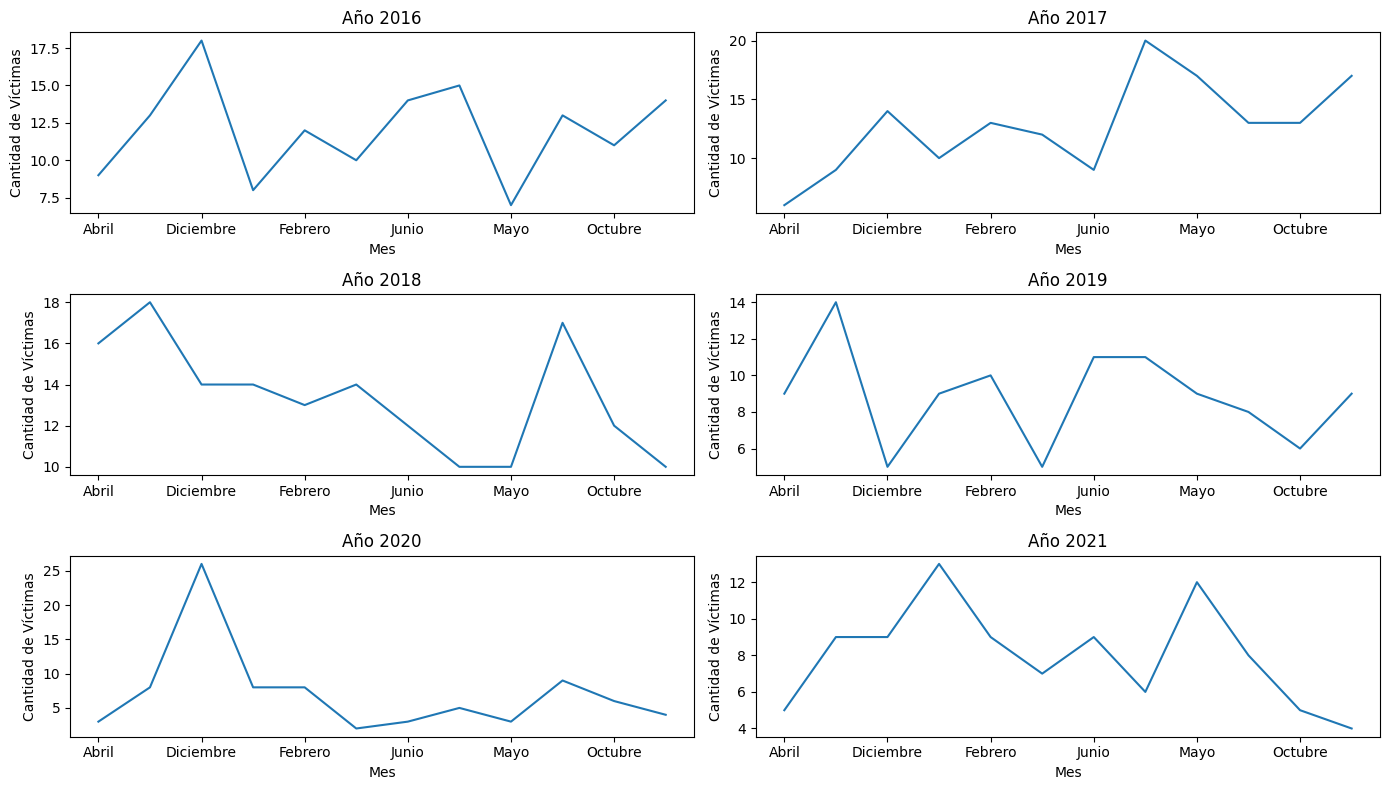

In [86]:
utils.accidentes_mensuales(siniestros_limpio)

De las gráficas anteriores, no se observa un patrón a lo largo del año comparando entre los distintos años. Los picos de accidentes fatales no se observan en los mismos meses en los distintos años registrados. Lo que se observa con claridad es la disminución notable de accidentes fatales desde Diciembre de 2019 hasta Noviembre de 2020, relacionado con las medidas de cuarentena por la pandemia COVID-19.

### Cantidad de víctimas Mensuales

El mes con menor cantidad de víctimas tiene 48 víctimas
El mes con mayor cantidad de víctimas tiene 86 víctimas


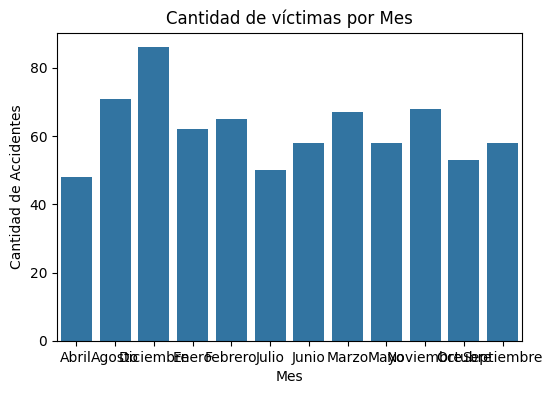

In [87]:
utils.cantidad_victimas_mensuales(siniestros_limpio)

Si se considera la distribución anual de todos los registros disponibles, se puede observar que el patrón que extiste a lo largo del año es un pico de accidentes en el mes de diciembre, siendo los meses con mas accidentes fatales Diciembre, Noviembre y Agosto. El mes con menos cantidad de accidentes fatales registrados es Julio y Septiembre.

### Distribución semanal

En este apartado se busca encontrar patrones en la cantidad de accidentes a lo largo de la semana.

El día de la semana con menor cantidad de víctimas tiene 100 víctimas
El día de la semana con mayor cantidad de víctimas tiene 114 víctimas
La diferencia porcentual es de 14.0


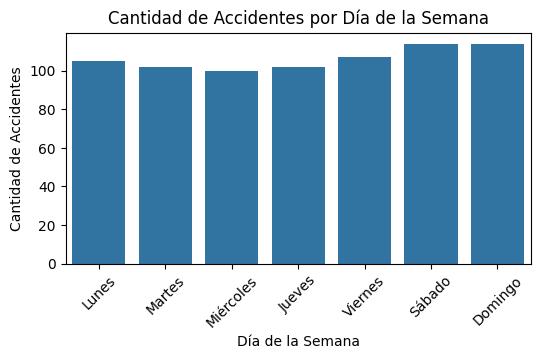

In [88]:
utils.cantidad_victimas_por_dia_semana(siniestros_limpio)

Considerando el total de los registros, la distribución de los accidentes tienden a registrarse entre los viernes a lunes, con el máximo regritrado el día Sábado y el mínimo el día Jueves. Sin embargo, la diferencia entre las cantidades mínima y máxima registrada en la semana es del 11.5% solamente.

### Distibución por momento del día

Para este análisis se creó una nueva columna donde se caracterizaran los diferentes momentos del día con el siguiente criterio:

* Mañana: de 6:00 a 10:59
* Medio día: de 11:00 a 13:59
* Tarde: de 14:00 a 18:59
* Noche: de 19:00 a 23:59
* Madrugada: de 24:00 a 05:59

A continuación, se observa la distribución de la cantidad de accidentes en cada una de estas categorías.

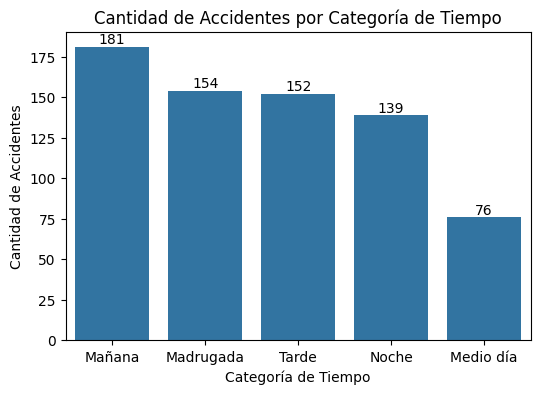

In [89]:
utils.cantidad_accidentes_por_categoria_tiempo(siniestros_limpio)

Se pueden apreciar que casi el 26% de los accidentes ocurren durante la mañana, donde la actividad laboral es alta. En el mediodía se registra un porcentaje considerablemente menor de cantidad de accidentes fatales respecto a los otros momentos del día.

#### Ahora, para mayor detalle, se observa la distribución horaria de los accidentes.

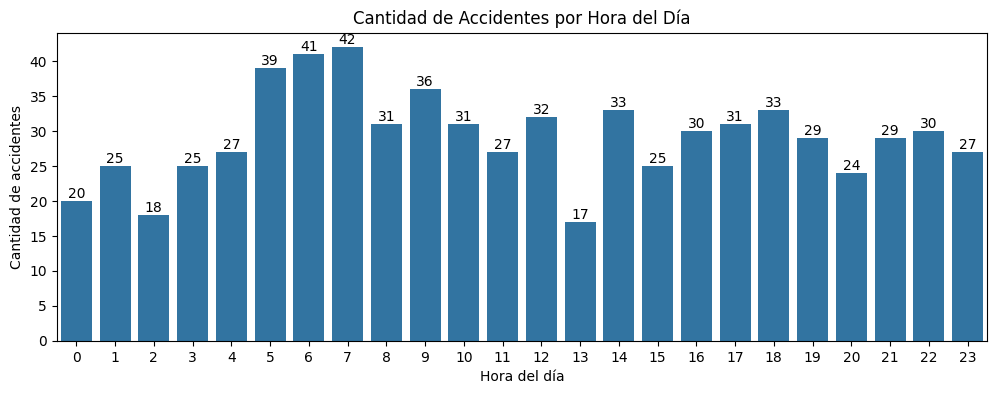

In [90]:
utils.cantidad_accidentes_por_horas_del_dia(siniestros_limpio)

Con mas detalle, observando hora a hora la distribución de los accidentes, es posible identificar el horario entre las 5 a las 8 de la mañana como el de mayor cantidad de accidentes. Luego se observa un poco a las 9 de la mañana seguido de tres momentos puntuales como lo son las 14 hs, las 18 hs y las 22 hs.

### Distribución días de la semana vs fines de semana

Lo que se busca en este punto es comparar la cantidad de accidentes en los días de semana (es decir, de lunes a viernes) y los fines de semana (sábado y domingo).

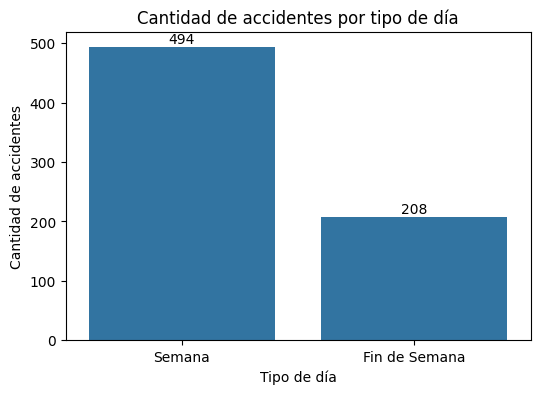

In [91]:
utils.cantidad_accidentes_semana_fin_de_semana(siniestros_limpio)

Del gráfico anterior se puede ver que la mayor cantidad de accidentes registrados fue durante la semana, siendo algo menos de la mitad los ocurridos el fin de semana. Esto contrasta con lo observado en el anterior análisis, donde se vieron las mayores cantidades entre el viernes y el lunes, aunque al acumular de lunes a viernes es una sola medida, es que los días de semana acumulan mas que los fines de semana.

### Edad de las víctimas

En este punto se busca entender el patrón de distribución de las edades de las víctimas. En los siguientes gráficos se muestra el histograma de edades uy un boxplot para entender su distribución de las mismas.

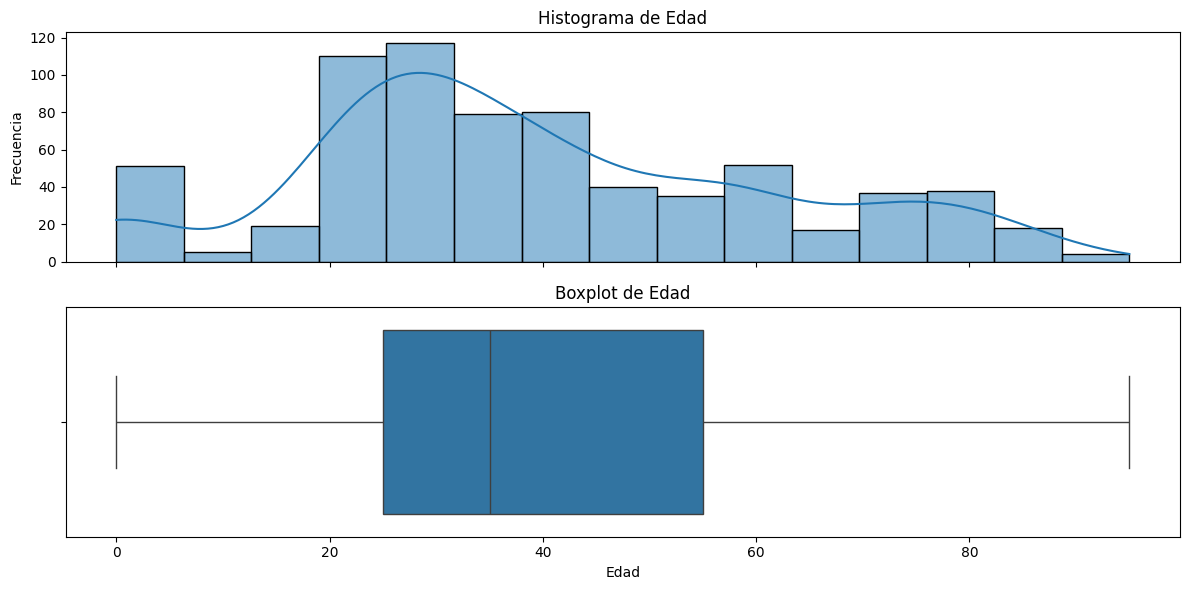

In [92]:
utils.distribucion_edad(siniestros_limpio)

Se puede apreciar en los gráficos anteriores, que el 75% de los accidentados es menor de 55 años, con una mediana de 39 años. No se observan edades atípicas. Si bien se observa un mínimo de 1 año y un máximo de 95 años, esto tiene que ver con el registro de todas las víctimas, no necesariamente son las que manejaban al momento del accidente. El histograma se observa con una distribución algo sesgada a la derecha, concentrando la mayor cantidad de accidentes entre los 20 a 40 años.



#### Se puede ver en detalle la distribución de las edades por año.

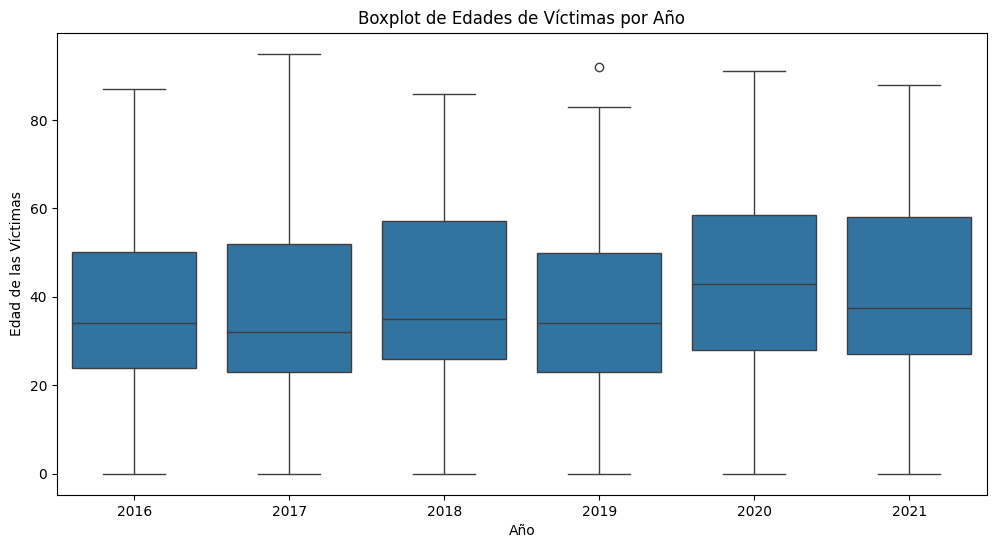

In [93]:
utils.distribucion_edad_por_anio(siniestros_limpio)

Las distribuciones de las edades se comportan muy parecido en los años registrados, con una mediana alrededor de los 40 años. Se observan algunos valores atípicos que tienen que ver con aultos mayores víctimas de los accidentes en los años 2016, 2017 y 2019.



#### Una relación interesante a ver es la variación entre los grupos de Masculinos y Femeninos según la edad.

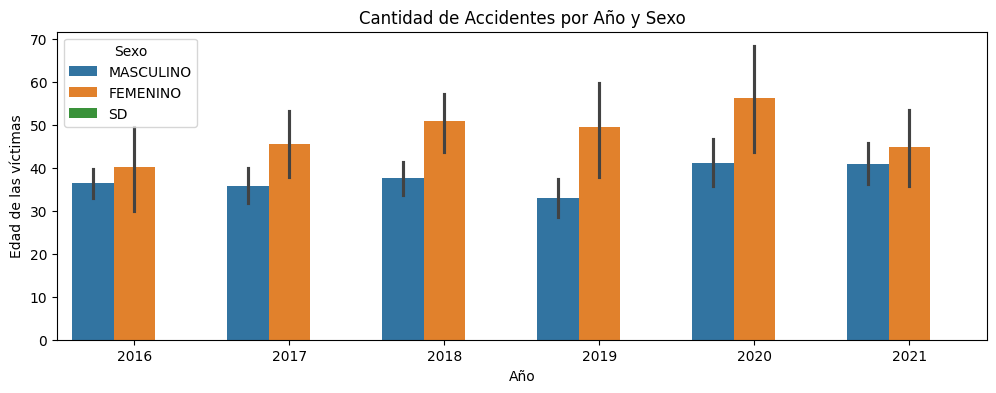

In [95]:
utils.cantidades_accidentes_por_anio_y_sexo(siniestros_limpio)

In [96]:
# Se observan los datos numéricos de ese gráfico
resumen_sexo_año = siniestros_limpio.groupby(['Año', 'Sexo']).size().reset_index(name='Cantidad accidentes')
resumen_sexo_año

,Año,Sexo,Cantidad accidentes
0,2016,FEMENINO,27
1,2016,MASCULINO,112
2,2016,SD,1
3,2017,FEMENINO,36
4,2017,MASCULINO,99
5,2018,FEMENINO,38
6,2018,MASCULINO,110
7,2019,FEMENINO,27
8,2019,MASCULINO,77
9,2020,FEMENINO,16


n el gráfico anterior se puede ver que hasta el 2020 había una tendencia creciente en las edades de las mujeres fallecidas que en hombres, con edades entre los 40 y 50 años, disminuyendo para 2021. En cuanto a los hombres, se observa una leve tendencia al aumento de la edad de fallecimientos pero sostenida alrededor de los 40 años de edad, pero igualmente menor edad que en mujeres.

Para analizar más concretamente la magnitud de la diferencia de estos dos grupos se decide utilizar el estadístico de Cohen, que es una medida utilizada en estadísticas que se utiliza comúnmente en el contexto de pruebas de hipótesis y comparación de grupos para determinar si una diferencia observada es significativa desde un punto de vista práctico. Se la denomina "d" y se calcula como:

<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>d</mi>
  <mo>=</mo>
  <mfrac>
    <mrow data-mjx-texclass="ORD">
      <mtext>Diferencia entre las medias de los grupos o condiciones</mtext>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mtext>Desviaci&#xF3;n est&#xE1;ndar combinada de los grupos o condiciones</mtext>
    </mrow>
  </mfrac>
</math>
 

Donde:

Diferencia entre las medias de los grupos o condiciones es la media del grupo 1 menos la media del grupo 2.
Desviación estándar combinada de los grupos o condiciones es la varianza combinada de dos grupos.
El valor resultante de 
 indica cuántas desviaciones estándar se encuentra la diferencia observada con respecto a la variabilidad de los datos. Un valor mayor de 
 indica una mayor magnitud del efecto, mientras que un valor menor de 
 indica un efecto más pequeño.

A continuación, se calcula el estadístico para todo el conjunto de datos, para conocer la diferencia entre los dos grupos de sexos y edades.

In [97]:
# Se definen los grupos
grupo1_completo = siniestros_limpio[siniestros_limpio['Sexo'] == 'MASCULINO']['Edad']
grupo2_completo = siniestros_limpio[siniestros_limpio['Sexo'] == 'FEMENINO']['Edad']
# Se calcula el Cohen
d = utils.cohen(grupo1_completo, grupo2_completo)
print(f'El valor de Cohen es: {round(d,2)}')

El valor de Cohen es: -0.48


Se presenta un valor de 
 de Cohen de -0.48 entre los dos grupos analizados, esto implica un efecto de tamaño moderado alto. Esto significa que hay una diferencia marcada en la edad promedio entre estos grupos con dirección hacia las mujeres, es decir, que en promedio el grupo hombres tiende a ser más joven en comparación con el grupo de mujeres, que es lo que se intuía desde el anterior gráfico.




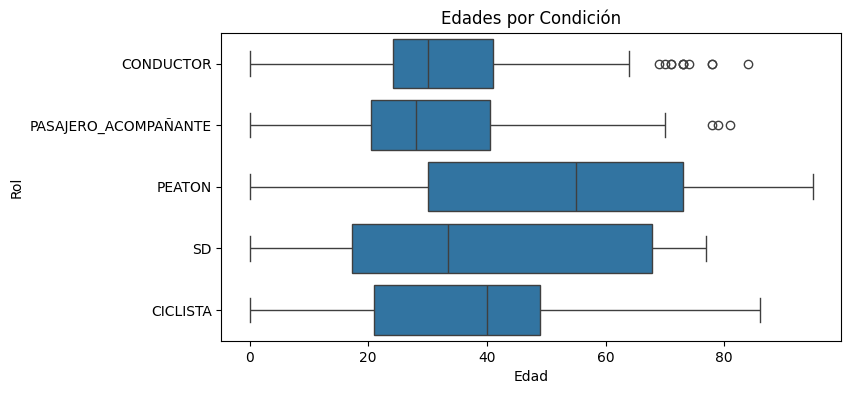

In [102]:
utils.edad_y_rol_victimas(siniestros_limpio)

De las edades promedio que se obeservan en los cuatro roles analizados, se encuentra que es similar la edad del conductor de auto y del pasajero acompañante, siendo de alrededor de los 35 años. Se observa que la edad mínima del conductor es de alrededor de los 18 años, pero en los demás roles es posible encontrar victimas de menor edad, lo que se se relaciona con ser niños que estan siendo trasladados.

En el caso de los peatones se observa mayor dispersión de las edades, desde niños muy pequeños a adultos mayores de cerca de los 90 años.

Si bien en conductor y pasajero acompañante se observan algunos valores atípicos, los mismos son edades esperables y se consideran casos especiales en el conjunto de datos.

Finalmente, se analiza la relación de la edad con los distintos vehículos que ocupaba la victima o si era peatón.

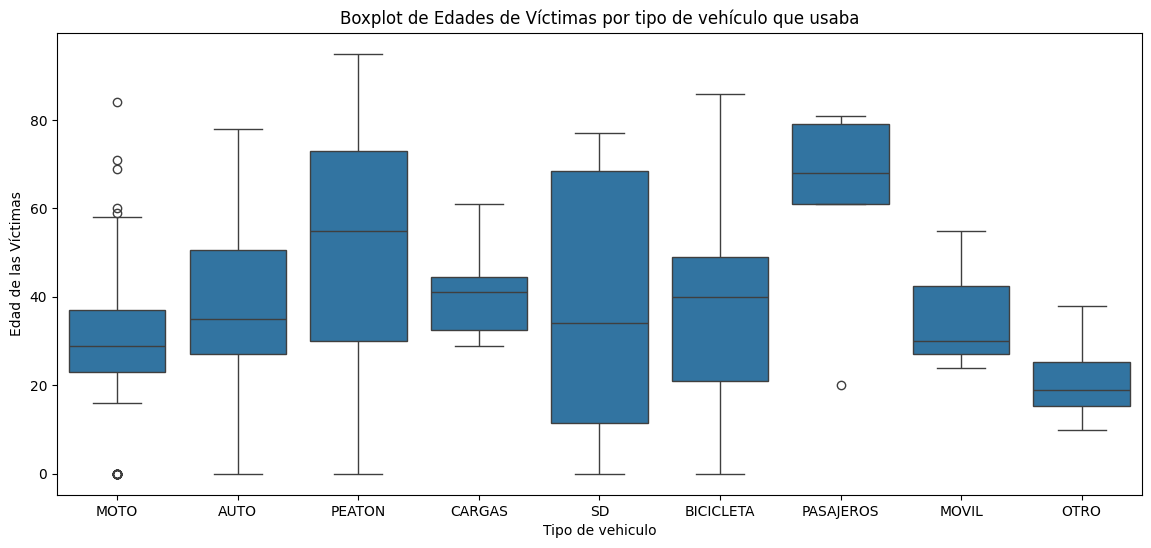

In [103]:
utils.distribucion_edad_por_victima(siniestros_limpio)

Se observa una gran dispersión de edades de víctimas fallecidas según el vehículo que ocupaban al momento del hecho. En el caso de victimas peatones es donde se observa un rango mas amplio de edades que en las demás categorías. Las victimas de mayor edad se observan mas concentradas cuando son pasajeros y victimas mas joven se observan en moto y otros.

### Sexo de las víctimas

Si bien ya se analizaron algunos puntos de sexo en relación con la edad, en este apartado se intenta analizar la relación del sexo con las cantidades de accidente, los roles y el tipo de vehículo que ocupaba o si era peatón.

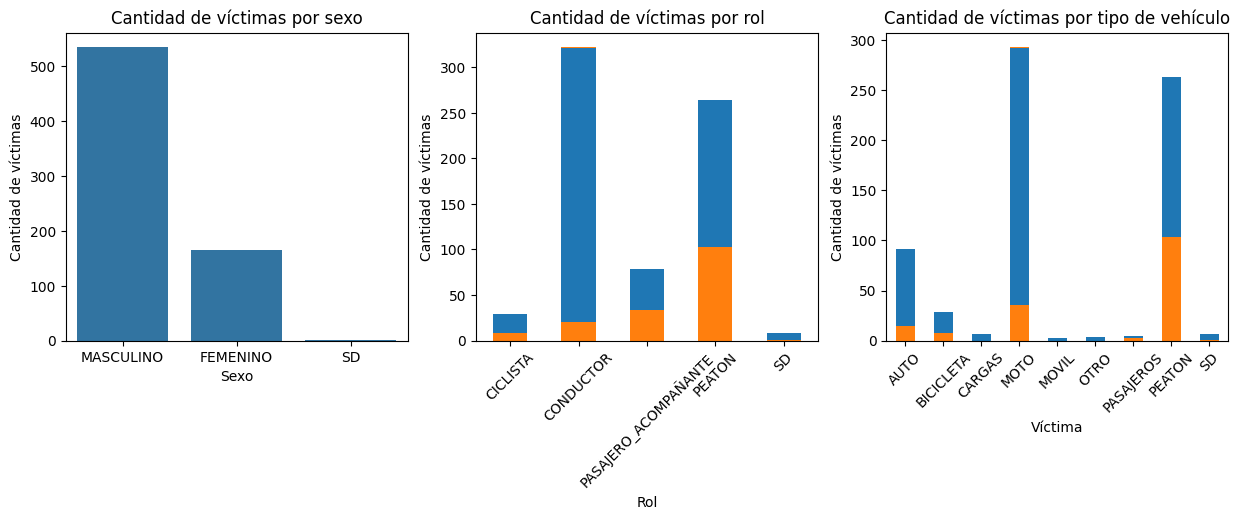

In [104]:
utils.cantidad_victimas_sexo_rol_victima(siniestros_limpio)

Se puede ver la diferencia en la cantidad de víctimas masculina por sobre las femeninas. Se aprecia la diferencia sobre todo en Conductor, donde la mayor proporción son masculinos y lo que llama la atención es que Motos es el vehículo con mayor proporción de accidentes con una alta proporción de masculinos. Los peatones también son las víctimas con mayor cantidad de fallecimientos en accidentes, con mayor proporción de masculinos, pero menos pronunciada la diferencia.

### Participantes en los accidentes

En este punto se analizan las cantidades de víctimas en función de los vehículos o medios de transporte que participaron de hecho.

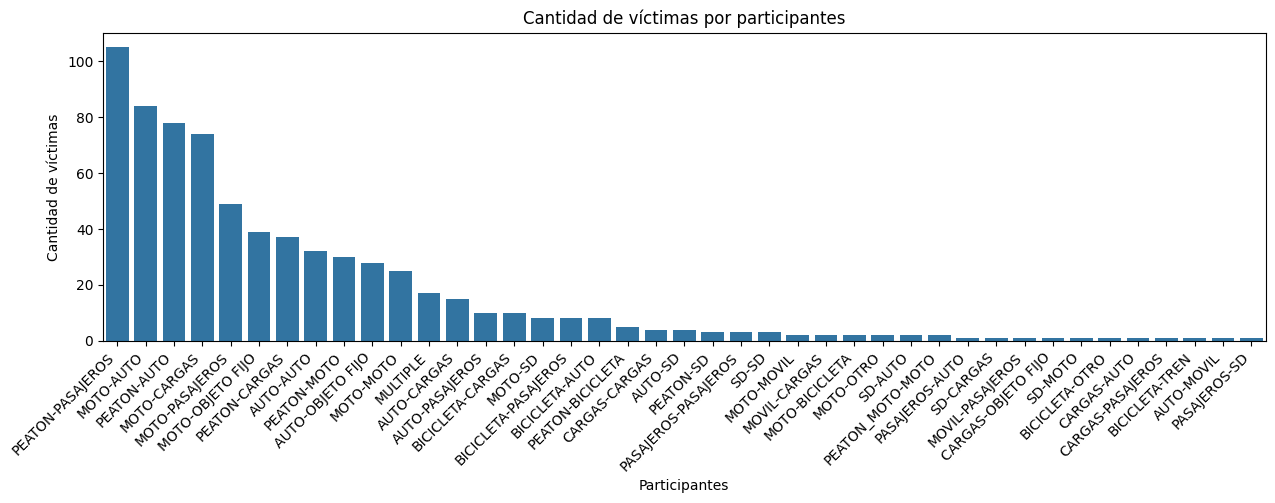

In [105]:
utils.cantidad_victimas_participantes(siniestros_limpio)

Resulta llamativo que la mayor cantidad de víctimas ocurren por hechos donde se involucran peatones con pasajeros. Según el diccionario de datos, Peatón es cualquier víctima distinta de cualquier ocupante de un vehículo, ya sea un conductor/a o un pasajero/a y Pasajero es cualquier personas lesionadas que se encuentran dentro, descendiendo o ascendiendo de las unidades de autotrasporte público de pasajeros/as y ómnibus de larga distancia. Para tratar de encontrar un sentido a este punto, se observan los casos de estos registros.

In [107]:
siniestros_limpio[siniestros_limpio['Participantes'] == 'PEATON-PASAJEROS'][['Participantes', 'Víctima', 'Acusado']]

,Participantes,Víctima,Acusado
13,PEATON-PASAJEROS,PEATON,PASAJEROS
21,PEATON-PASAJEROS,PEATON,PASAJEROS
23,PEATON-PASAJEROS,PEATON,PASAJEROS
27,PEATON-PASAJEROS,PEATON,PASAJEROS
34,PEATON-PASAJEROS,PEATON,PASAJEROS
...,...,...,...
679,PEATON-PASAJEROS,PEATON,PASAJEROS
684,PEATON-PASAJEROS,PEATON,PASAJEROS
685,PEATON-PASAJEROS,PEATON,PASAJEROS
706,PEATON-PASAJEROS,PEATON,PASAJEROS


Lo que se interpreta de ver los datos asociados al registro de Participante como Peaton-Pasajero, es que si la víctima es Peatón y el acusado es Pasajero, se debe estar refiriendo que el hecho ocurrió asociado a una persona que subía, bajaba o se trasladaba por algún medio de transporte público. A partir de aquí se considerará de esta manera, pero teniendo en cuenta esta observación hasta confirmar o rechazar por parte de los interesados.

Por otra parte, en el gráfico anterior, se llega a apreciar que los hechos que involucran moto, auto y cargas son los que mayor cantidad de víctimas acumulan.

### Acusados en los accidentes

In [108]:
siniestros_limpio.head(2)

,Id,Fecha,Año,Mes,Día,Hora entera,Hora,Cantidad víctimas,Participantes,Rol,...,coordenada_x,coordenada_y,Pos x,Pos y,Día semana,Nombre día,Categoria tiempo,Hora del día,Dia semana,Tipo de día
0,2016-0001,2016-01-01,2016,Enero,Jueves,4.0,04:00:00,1,MOTO-AUTO,CONDUCTOR,...,98896.782384,93532.434378,-58.47533969,-34.68757022,4,Viernes,Madrugada,4,4,Semana
1,2016-0002,2016-01-02,2016,Enero,Jueves,1.0,01:15:00,1,AUTO-PASAJEROS,CONDUCTOR,...,95832.055711,95505.416420,-58.50877521,-34.66977709,5,Sábado,Madrugada,1,5,Fin de Semana


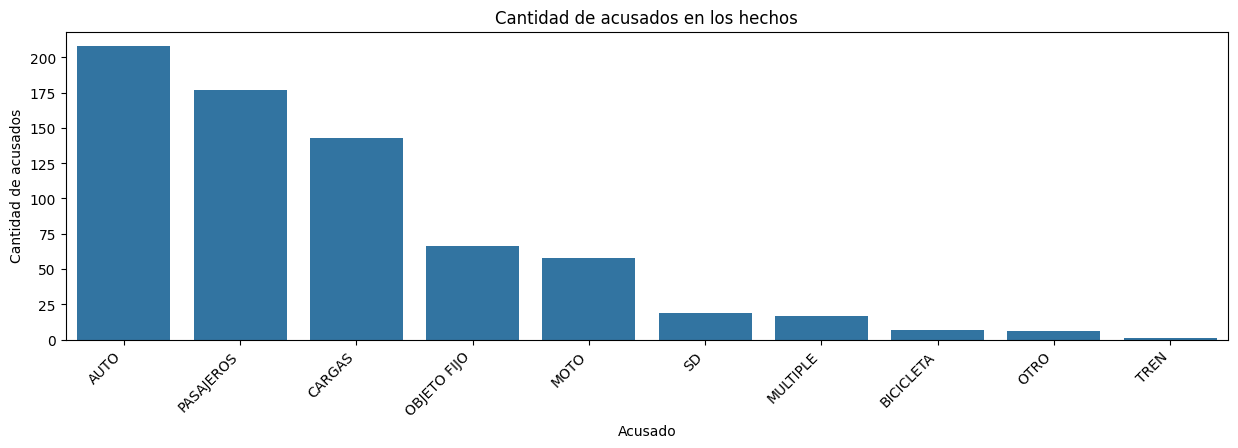

In [109]:
utils.cantidad_acusados(siniestros_limpio)

Lo que se interpreta de este gráfico es que la mayor responsabilidad en los hechos registrados es de los conductores de autos, seguidas de pasajeros y cargas (éste último se refiere a vehículos de carga). En cuanto a Pasajeros tiene sentido en relación con lo interpretado en el punto anterior, donde el vehículo involucrado es el transporte público, lo que da sentido a lo discutido.

### Tipo de calle donde ocurren los hechos

En este apartado lo que se busca en encontrar patrones en relación del tipo de calle donde ocurren los hechos y si son cruces de calles o no.

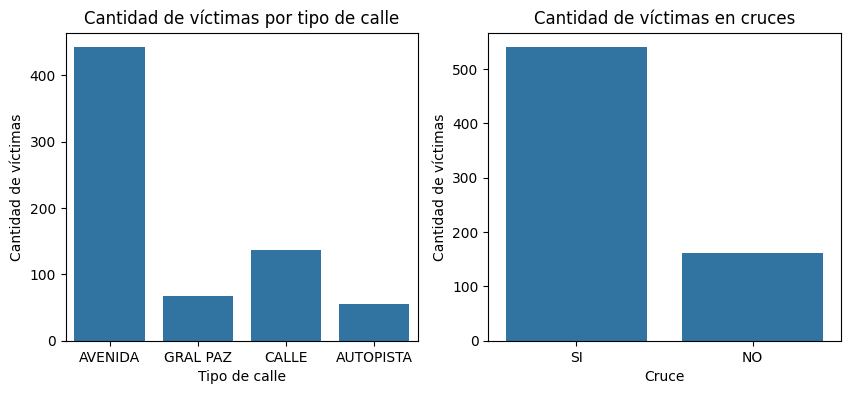

In [110]:
utils.accidentes_tipo_de_calle(siniestros_limpio)

Se pueden ver que la mayor cantidad de hechos con víctimas fatales ocurren en las avenidas y en particular en los cruces de calles.